# UDS Final Project
## Data Processing

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import dame_flame
from statsmodels.stats.weightstats import ttest_ind
from scipy import stats

In [144]:
# Read the data
df = pd.read_csv('https://raw.githubusercontent.com/MIDS-at-Duke/uds-2023-team-1/main/30_intermediate_files/complete_data.csv?token=GHSAT0AAAAAAB5CQTOTPLPJ5BAPIBJWQRGEZCFWI7A')
df.head()

,Unnamed: 0,Unnamed: 0_x,startdate,recordeddate,responseid,age,sex_birth,gender_male,gender_female,gender_transm,...,first_gen,week,state_abb,Unnamed: 0_y,week-year,state,new_case,state_new,2020,cases_per_10k
0,0,0,2022-04-11 15:09:58,2022-05-03 09:50:02,R_AuF1Zh0r7wJJY3L,19.0,2.0,1.0,0.0,0.0,...,False,18-2022,CA,2225,18-2022,CA,53178,California,39501653,13.462221
1,1,1,2022-04-17 04:27:57,2022-04-17 04:48:29,R_3nI424DBkE5Ixmt,19.0,1.0,0.0,1.0,0.0,...,False,16-2022,CA,1985,16-2022,CA,37047,California,39501653,9.378595
2,2,2,2022-04-22 09:54:31,2022-04-22 13:49:38,R_32J8GAWh6IOIYxm,20.0,2.0,1.0,0.0,0.0,...,True,16-2022,CA,1985,16-2022,CA,37047,California,39501653,9.378595
3,3,3,2022-04-13 18:48:59,2022-05-03 09:52:47,R_1lizI3iHB2UE7O1,18.0,2.0,1.0,0.0,0.0,...,NaN,18-2022,CA,2225,18-2022,CA,53178,California,39501653,13.462221
4,4,4,2022-04-21 17:14:42,2022-05-03 09:56:15,R_3ELrwNOuqQ7bzmP,49.0,1.0,0.0,1.0,0.0,...,False,18-2022,CA,2225,18-2022,CA,53178,California,39501653,13.462221


## Data Cleaning

1. Remove unnecessary columns
2. Remove outliers
3. Fill in missing values:
- remove rows where target or treatment variables missing
- remove columns with over 50k  missing values making imputation practically infeasible
- fill in "unknown" or "other" when suitable
- fill in "0s" or "1s" for suitable fields. Assume most likely (most frequent) value.
- knn imputation for numerical and multicategorical fields

In [145]:
# removing outliers
df[df['hours_work_paid'] > 120] = np.nan
df[df['sleep_wknight'] >= 24] = np.nan

## Missing Values

In [146]:
# let's delete rows where the target variable anxiety treatment is missing
df.dropna(subset=['anxiety'], inplace=True)
df.dropna(subset=['covid_clsformat'], inplace=True)
print(df.shape)

(84870, 96)


In [147]:
def fill_in(df, cols, value = 1):
    for col in cols:
        df[col] = df[col].fillna(value)
    return df

In [148]:
# fill in with 1s
cols_1 = ['food_notlast', 'food_worry', 'deport_worry', 'alc_any', 'enroll', 'children_dep'] #alc_any and enroll harder to justify

# fill in with 0s
cols_0 = ['disab_2', 'sub_cig', 'sub_any', 'dx_any', 'meds_any', 'sui_idea', 'lone_isolated', 'assault_emo', 'hours_work_paid', 'international']

# fill in with 3s
cols_3 = ['disab_1']

# fill in with 7s - unknown
cols_7 = ['educ_par2', 'educ_par1', 'positive_mental_health', 'sex_birth']

# fill in with False
cols_false = ['first_gen']

# knn imputation
cols_knn_imp = ['knowwher', 'sleep_wknight', 'exerc', 'persist', 'yr_sch', 'timestud', 'finpast', 'fincur', 'abuse_life', 'satisfied_overall']

# columns to delete
cols_del = ['q2_wtg_3', 'q2_wtg_6_1', 'env_mh', 'camp_supp', 'percneed', 'Unnamed: 0', 'Unnamed: 0_x']

# categorical imputation - most frequent - hard to justify, but ok for now
cols_q = ['risk_of_depression']

In [149]:
df = fill_in(df, cols_1, 1)
df = fill_in(df, cols_0, 0)
df = fill_in(df, cols_3, 3)
df = fill_in(df, cols_7, 7)
df = fill_in(df, cols_false, False)

In [150]:
# delete unnecessary columns
df.drop(columns=cols_del, inplace=True, axis=1)

In [151]:
# KNN imputation
imputer = KNNImputer(n_neighbors=1)
imputed = imputer.fit_transform(df[df.describe().columns.to_list()])

In [152]:
for col in df.describe().columns.to_list():
    df[col] = imputed[:, df.describe().columns.to_list().index(col)]

In [153]:
# most frequent imputation
df[cols_q[0]] = df[cols_q[0]].fillna(df[cols_q[0]].mode().iloc[0])

In [154]:
# create binary variable for treatment
df['is_online'] = df['covid_clsformat'].replace({1: 0, 2: 1, 3: 1}).copy()

# remove rows where is_online = 4. These are other and we can exclude those.
df = df[df['is_online'] != 4]

# remove rows where the enrollment is "other". We have no information about these students.
df = df[df['enroll'] != 3]

# remove covid_clsformat
df.drop(columns=['covid_clsformat'], inplace=True, axis=1)

In [157]:
# check that there are no nulls in the dataset
df.isnull().sum().sum() == 0

True

In [158]:
# run this if you just want all the data
df.to_csv('all_data.csv')

## Matching Process

In [246]:
# skip if you ran the previous cells

df = pd.read_csv('all_data.csv')

In [247]:
# convert categorical to numerical for matching
df['positive_mental_health'] = df['positive_mental_health'].replace({"Not flourishing": 0, "Flourishing": 1})
df['risk_of_depression'] = df['risk_of_depression'].replace({"Mild": 1, "Minimal": 2, "Moderate": 3, "Moderately severe": 4, "Severe": 5})
df['first_gen'] = df['first_gen'].replace({False: 0, True: 1})

In [248]:
# print shape
print("The shape of the data is: ", df.shape)

The shape of the data is:  (82387, 90)


We want to limit our number of columns to consider when doing matching. We'll only going to match on fields that are highly correlated (> 0.15) with our treatment and outcome variables.

In [249]:
# create a dataframe to show correlation between output and treatment variables
X = df.drop(columns=['anxiety', 'is_online']).copy()
anx = df['anxiety'].copy()
online = df['is_online'].copy()
corr_data = pd.concat([X, anx], axis=1)
corr_anxiety = corr_data.corr()['anxiety'].sort_values(ascending=False)
corr_data = pd.concat([X, online], axis=1)
corr_online = corr_data.corr()['is_online'].sort_values(ascending=False)

In [250]:
df.columns

Index(['Unnamed: 0', 'startdate', 'recordeddate', 'responseid', 'age',
       'sex_birth', 'gender_male', 'gender_female', 'gender_transm',
       'gender_transf', 'sexual_other', 'gender_nonbin', 'gender_selfid',
       'sexual_h', 'sexual_l', 'sexual_g', 'sexual_bi', 'sexual_queer',
       'sexual_quest', 'sexual_asexual', 'sexual_pan', 'race_black',
       'race_ainaan', 'race_asian', 'race_his', 'race_pi', 'race_mides',
       'race_white', 'race_other', 'international', 'educ_par1', 'educ_par2',
       'scholarship_status_1', 'children_dep', 'hours_work_paid', 'transfer',
       'yr_sch', 'enroll', 'persist', 'disab_1', 'disab_2',
       'positive_mental_health', 'risk_of_depression', 'anxiety', 'timestud',
       'sui_idea', 'lone_isolated', 'abuse_life', 'assault_emo', 'alc_any',
       'sub_cig', 'sub_any', 'exerc', 'sleep_wknight', 'dx_any', 'knowwher',
       'meds_any', 'degree_ass', 'degree_bach', 'degree_ma', 'degree_jd',
       'degree_md', 'degree_phd', 'degree_other', '

In [251]:
cols1 = corr_anxiety[abs(corr_anxiety) > 0.20].index.to_list()
cols1

['anxiety',
 'risk_of_depression',
 'lone_isolated',
 'dx_any',
 'sui_idea',
 'persist',
 'meds_any',
 'abuse_life',
 'sexual_h',
 'finpast',
 'satisfied_overall',
 'fincur']

In [252]:
cols2 = corr_online[abs(corr_online) > 0.20].index.to_list()
cols2

['is_online', 'degree_ass', 'hours_work_paid', 'age', 'enroll', 'degree_bach']

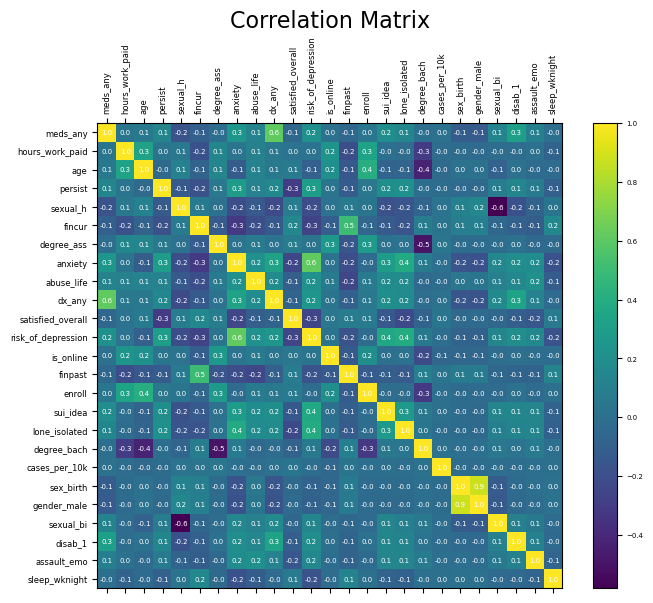

In [253]:
columns_to_use = list(set(cols1 + cols2)) + ['cases_per_10k'] + ['sex_birth', 'gender_male', 'sexual_bi', 'disab_1', 'assault_emo', 'sleep_wknight']
corr_data = df[columns_to_use]

f = plt.figure(figsize=(8, 6))
corr = corr_data.corr()
corr.style.background_gradient(cmap='RdYlGn').format(precision=2)
plt.matshow(corr, fignum=f.number)
for (i, j), z in np.ndenumerate(corr):
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', fontsize=5, color='white')
plt.xticks(range(corr_data.select_dtypes(['number']).shape[1]), corr_data.select_dtypes(['number']).columns, fontsize=6, rotation=90)
plt.yticks(range(corr_data.select_dtypes(['number']).shape[1]), corr_data.select_dtypes(['number']).columns, fontsize=6)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=5)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [254]:
# exclude: meds_any, finpast, sexual_bi, degree_ass, gender_male 
to_exclude = ['meds_any', 'finpast', 'sexual_bi', 'degree_ass', 'gender_male']
for col in to_exclude:
    columns_to_use.remove(col)

Coarsening numerical fields

In [255]:
def get_categorical_bucket(x, low, high):
    if x <= low:
        return 0
    elif x <= high and x > low:
        return 1
    else:
        return 2

In [257]:
# coarsening the numerical fields
hours_work_paid_low, hours_work_paid_high = df['hours_work_paid'].describe()['50%'],  df['hours_work_paid'].describe()['75%']
df['hours_work_paid'] = df['hours_work_paid'].apply(get_categorical_bucket, args=(hours_work_paid_low, hours_work_paid_high))

In [258]:
age_low, age_high = df['age'].describe()['25%'],  df['age'].describe()['75%']
df['age'] = df['age'].apply(get_categorical_bucket, args=(age_low,  age_high))

In [259]:
cases_low, cases_high = df['cases_per_10k'].describe()['25%'],  df['cases_per_10k'].describe()['75%']
df['cases_per_10k'] = df['cases_per_10k'].apply(get_categorical_bucket, args=(cases_low, cases_high))

In [260]:
sleep_low, sleep_high = df['sleep_wknight'].describe()['25%'],  df['sleep_wknight'].describe()['75%']
df['sleep_wknight'] = df['sleep_wknight'].apply(get_categorical_bucket, args=(sleep_low, sleep_high))

In [261]:
dame_model = dame_flame.matching.FLAME(verbose = 3, want_pe = True, early_stop_iterations=20)

In [263]:
dame_model.fit(
    df[columns_to_use],
    treatment_column_name='is_online',
    outcome_column_name='anxiety',
)
result = dame_model.predict(df[columns_to_use])

Completed iteration 0 of matching
	Number of matched groups formed in total:  2688
	Unmatched treated units:  33814 out of a total of  37856 treated units
	Unmatched control units:  38981 out of a total of  44531 control units
	Number of matches made this iteration:  9592
	Number of matches made so far:  9592
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  36.90884130503085
Completed iteration 1 of matching
	Number of matched groups formed in total:  5434
	Unmatched treated units:  31243 out of a total of  37856 treated units
	Unmatched control units:  35141 out of a total of  44531 control units
	Number of matches made this iteration:  6411
	Number of matches made so far:  16003
	Covariates dropped so far:  cases_per_10k
	Predictive error of covariate set used to match:  36.90886982759666
Completed iteration 2 of matching
	Number of matched groups formed in total:  8318
	Unmatched treated units:  28276 out of a total of  37856 treated units
	Unmat

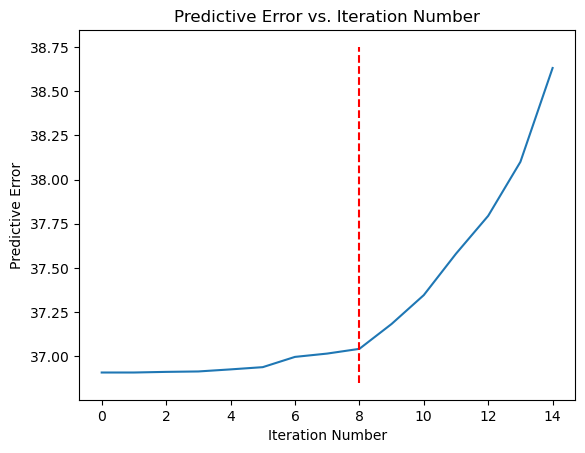

In [271]:
plt.plot(dame_model.pe_each_iter)
plt.vlines(8, 36.85, 38.75, colors='r', linestyles='dashed', label = 'cutoff')
plt.title("Predictive Error vs. Iteration Number")
plt.xlabel("Iteration Number")
plt.ylabel("Predictive Error")
plt.legend()
plt.show()

In [43]:
def get_dataframe(model, result_of_fit):

    # Get original data
    better = model.input_data.loc[result_of_fit.index]
    if not better.index.is_unique:
        raise ValueError("Need index values in input data to be unique")

    # Get match groups for clustering
    better["match_group"] = np.nan
    better["match_group_size"] = np.nan
    for idx, group in enumerate(model.units_per_group):
        better.loc[group, "match_group"] = idx
        better.loc[group, "match_group_size"] = len(group)

    # Get weights. I THINK this is right?! At least for with repeat=False?
    t = model.treatment_column_name
    better["t_in_group"] = better.groupby("match_group")[t].transform(np.sum)

    # Make weights
    better["weights"] = np.nan
    better.loc[better[t] == 1, "weights"] = 1  # treaments are 1

    # Controls start as proportional to num of treatments
    # each observation is matched to.
    better.loc[better[t] == 0, "weights"] = better["t_in_group"] / (
        better["match_group_size"] - better["t_in_group"]
    )

    # Then re-normalize for num unique control observations.
    control_weights = better[better[t] == 0]["weights"].sum()

    num_control_obs = len(better[better[t] == 0].index.drop_duplicates())
    renormalization = num_control_obs / control_weights
    better.loc[better[t] == 0, "weights"] = (
        better.loc[better[t] == 0, "weights"] * renormalization
    )
    assert better.weights.notnull().all()

    better = better.drop(["t_in_group"], axis="columns")

    # Make sure right length and values!
    assert len(result_of_fit) == len(better)
    #assert better.loc[better[t] == 0, "weights"].sum() == num_control_obs

    return better

In [87]:
matched_results = get_dataframe(dame_model, result)

In [88]:
matched_final = df.loc[matched_results.index.to_list()].copy()
matched_final['weights'] = matched_results['weights'].copy()
matched_final['match_group_size'] = matched_results['match_group_size'].copy()
matched_final['match_group'] = matched_results['match_group'].copy()


In [89]:
matched_final

,startdate,recordeddate,responseid,age,sex_birth,gender_male,gender_female,gender_transm,gender_transf,sexual_other,...,week-year,state,new_case,state_new,2020,cases_per_10k,is_online,weights,match_group_size,match_group
10,2022-04-15 13:40:00,2022-04-15 16:36:31,R_1qdE55ZSFYCZrfT,22.0,1.0,0.0,1.0,0.0,0.0,0.0,...,15-2022,CA,25540.0,California,39501653.0,6.465552,1.0,1.000000,2.0,6758.0
30,2022-04-15 13:57:00,2022-04-18 01:49:06,R_3CKuFuUtPmHgA4A,19.0,1.0,0.0,1.0,0.0,0.0,1.0,...,16-2022,CA,37047.0,California,39501653.0,9.378595,0.0,1.301263,14.0,4300.0
32,2022-04-22 04:53:48,2022-04-22 05:31:01,R_8p7tjz4GhEAmh5T,18.0,1.0,0.0,1.0,0.0,0.0,0.0,...,16-2022,CA,37047.0,California,39501653.0,9.378595,1.0,1.000000,9.0,7195.0
35,2022-04-13 22:57:26,2022-04-13 23:23:02,R_1gOBnk1jeWftXyX,27.0,1.0,0.0,1.0,0.0,0.0,0.0,...,15-2022,CA,25540.0,California,39501653.0,6.465552,1.0,1.000000,2.0,8241.0
43,2022-04-21 23:52:51,2022-04-22 01:45:34,R_3NQELamlwLfumxZ,20.0,1.0,0.0,1.0,0.0,0.0,0.0,...,16-2022,CA,37047.0,California,39501653.0,9.378595,1.0,1.000000,4.0,2998.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95835,2022-02-24 11:48:01,2022-03-14 12:43:04,R_2wdjxARlh3slIUb,20.0,1.0,0.0,1.0,0.0,0.0,0.0,...,11-2022,WA,6788.0,Washington,7724031.0,8.788157,0.0,0.433754,4.0,3461.0
95841,2022-03-01 15:50:29,2022-03-01 16:41:34,R_xz5wTwTl2cziKn7,21.0,2.0,1.0,0.0,0.0,0.0,0.0,...,09-2022,WA,13386.0,Washington,7724031.0,17.330329,0.0,0.650632,3.0,4969.0
95846,2022-02-24 11:12:48,2022-02-24 11:38:03,R_3Phlh7fRbOt6Crq,18.0,1.0,0.0,1.0,0.0,0.0,0.0,...,08-2022,WA,18325.0,Washington,7724031.0,23.724659,0.0,0.459269,23.0,7143.0
95848,2022-02-17 11:35:40,2022-02-17 13:11:29,R_2QE9VA5ysKyidnS,18.0,2.0,1.0,0.0,0.0,0.0,0.0,...,07-2022,WA,19381.0,Washington,7724031.0,25.091821,0.0,0.130126,11.0,3371.0


### Chi-Square Test To Ensure Balance

In [141]:
len(columns_to_use)

26

In [90]:
final_df = matched_final.copy()

In [91]:
for col in columns_to_use:
    frequencies = pd.crosstab(final_df[col], final_df['is_online'])
    chi2, p, dof, ex = stats.chi2_contingency(frequencies)
    print("The p-value of {} the chi-squared test is: {:.4f}".format(col, p))

The p-value of meds_any the chi-squared test is: 0.3750
The p-value of fincur the chi-squared test is: 0.0000
The p-value of finpast the chi-squared test is: 0.0000
The p-value of sui_idea the chi-squared test is: 0.0028
The p-value of lone_isolated the chi-squared test is: 0.0000
The p-value of hours_work_paid the chi-squared test is: 0.0000
The p-value of age the chi-squared test is: 0.0017
The p-value of anxiety the chi-squared test is: 0.0000
The p-value of dx_any the chi-squared test is: 0.0017
The p-value of is_online the chi-squared test is: 0.0000
The p-value of sexual_h the chi-squared test is: 0.1975
The p-value of abuse_life the chi-squared test is: 0.0000
The p-value of risk_of_depression the chi-squared test is: 0.0000
The p-value of enroll the chi-squared test is: 0.0000
The p-value of degree_bach the chi-squared test is: 0.0000
The p-value of persist the chi-squared test is: 0.0028
The p-value of degree_ass the chi-squared test is: 0.0000
The p-value of satisfied_overall

In [94]:
a = final_df[final_df['is_online'] == 1]['cases_per_10k']
b = final_df[final_df['is_online'] == 0]['cases_per_10k']
stats.ttest_ind(a, b)

Ttest_indResult(statistic=-10.564898211654121, pvalue=5.1637304262604214e-26)

In [93]:
# send to data folder
final_df.to_csv('matched_data_18k.csv')

## Testing

In [97]:
s = pd.read_csv("https://raw.githubusercontent.com/MIDS-at-Duke/uds-2023-team-1/main/30_intermediate_files/matched_data_new.csv?token=GHSAT0AAAAAAB5CQTOTFBBIR3YRPO5YMGQSZB7OBRA")

In [98]:
s

,Unnamed: 0,startdate,recordeddate,responseid,age,sex_birth,gender_male,gender_female,gender_transm,gender_transf,...,weights,match_group_size,match_group,week-year,state,new_case,state_new,2020,cases_per_cap,cases_per_10k
0,0,2022-04-22 09:54:31,2022-04-22 13:49:38,R_32J8GAWh6IOIYxm,20.0,2.0,1.0,0.0,0.0,0.0,...,1.000000,2.0,11748.0,16-2022,CA,37047,California,39501653,0.000938,9.378595
1,1,2022-04-11 12:35:38,2022-04-11 12:59:31,R_72I28iy8iqGtOnL,27.0,2.0,1.0,0.0,0.0,0.0,...,0.394260,4.0,7143.0,15-2022,CA,25540,California,39501653,0.000647,6.465552
2,2,2022-04-15 13:40:00,2022-04-15 16:36:31,R_1qdE55ZSFYCZrfT,22.0,1.0,0.0,1.0,0.0,0.0,...,1.000000,2.0,13890.0,15-2022,CA,25540,California,39501653,0.000647,6.465552
3,3,2022-04-12 18:50:55,2022-04-12 19:10:41,R_WjGvkFnenaDKdwd,19.0,1.0,0.0,1.0,0.0,0.0,...,1.182779,2.0,5052.0,15-2022,CA,25540,California,39501653,0.000647,6.465552
4,4,2022-04-15 18:21:14,2022-04-15 18:52:05,R_2ciNNqFgeQYt2pR,19.0,2.0,1.0,0.0,0.0,0.0,...,1.182779,2.0,16008.0,15-2022,CA,25540,California,39501653,0.000647,6.465552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40049,40049,2022-02-17 11:35:40,2022-02-17 13:11:29,R_2QE9VA5ysKyidnS,18.0,2.0,1.0,0.0,0.0,0.0,...,0.394260,12.0,1121.0,07-2022,WA,19381,Washington,7724031,0.002509,25.091821
40050,40050,2022-03-07 14:57:10,2022-03-07 15:31:12,R_32XRK74koJFNke2,19.0,1.0,0.0,1.0,0.0,0.0,...,0.394260,4.0,3032.0,10-2022,WA,8093,Washington,7724031,0.001048,10.477690
40051,40051,2022-02-24 20:04:13,2022-02-24 20:50:35,R_7NYtlZIPoo4LyUh,20.0,2.0,1.0,0.0,0.0,0.0,...,1.182779,2.0,16408.0,08-2022,WA,18325,Washington,7724031,0.002372,23.724659
40052,40052,2022-03-01 14:24:55,2022-03-01 21:51:29,R_2Ep0PMy8iM5lXmG,21.0,1.0,0.0,0.0,0.0,0.0,...,1.182779,4.0,7017.0,09-2022,WA,13386,Washington,7724031,0.001733,17.330329


In [100]:
s[s['is_online'] == 1].describe()

,Unnamed: 0,age,sex_birth,gender_male,gender_female,gender_transm,gender_transf,sexual_other,gender_nonbin,gender_selfid,...,food_notlast,first_gen,is_online,weights,match_group_size,match_group,new_case,2020,cases_per_cap,cases_per_10k
count,18350.000000,18350.000000,18350.000000,18350.000000,18350.000000,18350.000000,18350.000000,18350.000000,18350.000000,18350.000000,...,18350.000000,18350.000000,18350.0,18350.0,18350.000000,18350.000000,18350.000000,1.835000e+04,18350.000000,18350.000000
mean,20761.981144,21.215640,1.250736,0.243215,0.710082,0.008719,0.002016,0.019673,0.032861,0.005995,...,1.051281,0.147357,1.0,1.0,2.765886,7929.968992,18683.491662,1.263698e+07,0.001653,16.525424
std,11028.337204,3.776173,0.459805,0.429036,0.453737,0.092972,0.044860,0.138878,0.178278,0.077194,...,0.295731,0.354471,0.0,0.0,2.160418,4846.958062,25276.785652,1.246657e+07,0.002223,22.230905
min,0.000000,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.0,1.0,2.000000,0.000000,-15.000000,6.428930e+05,-0.000008,-0.076428
25%,11620.250000,19.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.0,1.0,2.000000,3619.000000,3359.000000,3.597362e+06,0.000603,6.034978
50%,21159.000000,20.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.0,1.0,2.000000,7770.500000,8329.000000,6.995729e+06,0.000938,9.378595
75%,30983.750000,22.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.0,1.0,3.000000,12121.750000,25144.000000,1.179752e+07,0.002001,20.010143
max,40045.000000,68.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,3.000000,1.000000,1.0,1.0,32.000000,16580.000000,193681.000000,3.950165e+07,0.018230,182.296179


In [101]:
s[s['is_online'] == 0].describe()

,Unnamed: 0,age,sex_birth,gender_male,gender_female,gender_transm,gender_transf,sexual_other,gender_nonbin,gender_selfid,...,food_notlast,first_gen,is_online,weights,match_group_size,match_group,new_case,2020,cases_per_cap,cases_per_10k
count,21704.000000,21704.000000,21704.000000,21704.000000,21704.000000,21704.000000,21704.000000,21704.000000,21704.000000,21704.000000,...,21704.000000,21704.000000,21704.0,21704.000000,21704.000000,21704.000000,21704.000000,2.170400e+04,21704.000000,21704.000000
mean,19404.675498,21.014444,1.304368,0.296443,0.663472,0.007418,0.001705,0.018199,0.030501,0.004746,...,1.037643,0.100028,0.0,1.000000,3.480649,7455.102055,17215.536721,1.016537e+07,0.001995,19.952297
std,11961.019948,3.565248,0.483204,0.456699,0.472533,0.085810,0.041254,0.133675,0.171966,0.068727,...,0.254549,0.300044,0.0,0.482390,3.375690,4901.910014,25171.180094,9.707593e+06,0.002808,28.084943
min,1.000000,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.0,0.078852,2.000000,0.000000,-15.000000,6.428930e+05,-0.000008,-0.076428
25%,8864.750000,19.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.0,0.591390,2.000000,3136.750000,3668.000000,4.244795e+06,0.000647,6.471409
50%,18701.500000,20.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.0,1.182779,2.000000,6971.500000,7725.000000,6.995729e+06,0.001104,11.037907
75%,29001.250000,22.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.0,1.182779,3.000000,11694.250000,22791.000000,1.179752e+07,0.002180,21.804045
max,40053.000000,68.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,3.000000,1.000000,0.0,7.096676,32.000000,16580.000000,193681.000000,3.950165e+07,0.018230,182.296179


In [113]:
df[df['is_online'] == 1].describe()

,age,sex_birth,gender_male,gender_female,gender_transm,gender_transf,sexual_other,gender_nonbin,gender_selfid,sexual_h,...,deport_worry,fincur,finpast,food_worry,food_notlast,Unnamed: 0_y,new_case,2020,cases_per_10k,is_online
count,38302.000000,38302.000000,38302.000000,38302.000000,38302.000000,38302.000000,38302.000000,38302.000000,38302.000000,38302.000000,...,38302.000000,37608.000000,37571.000000,38302.000000,38302.000000,38302.000000,38302.000000,3.830200e+04,38302.000000,38302.0
mean,25.062764,1.248003,0.236854,0.714245,0.008772,0.002506,0.020782,0.034907,0.006605,0.708501,...,1.078220,2.664460,2.980836,1.055663,1.054305,2213.933476,20365.822098,1.389145e+07,16.674014,1.0
std,8.692962,0.465269,0.425158,0.451779,0.093251,0.050002,0.142656,0.183546,0.081006,0.454459,...,0.384813,1.090048,1.258965,0.299662,0.299214,1448.139389,26330.786221,1.339141e+07,21.744980,0.0
min,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,460.000000,-15.000000,6.428930e+05,-0.076428,1.0
25%,20.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,2.000000,1.000000,1.000000,1276.000000,3618.000000,3.597362e+06,6.220133,1.0
50%,22.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,3.000000,3.000000,1.000000,1.000000,1792.000000,8841.000000,8.636471e+06,9.378595,1.0
75%,27.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,3.000000,4.000000,1.000000,1.000000,2225.000000,25540.000000,1.299444e+07,19.814947,1.0
max,101.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,4.000000,5.000000,5.000000,3.000000,3.000000,5690.000000,193681.000000,3.950165e+07,182.296179,1.0


In [114]:
df[df['is_online'] == 0].describe()

,age,sex_birth,gender_male,gender_female,gender_transm,gender_transf,sexual_other,gender_nonbin,gender_selfid,sexual_h,...,deport_worry,fincur,finpast,food_worry,food_notlast,Unnamed: 0_y,new_case,2020,cases_per_10k,is_online
count,44722.000000,44722.000000,44722.000000,44722.000000,44722.000000,44722.000000,44722.000000,44722.000000,44722.000000,44722.000000,...,44722.000000,44415.000000,44380.000000,44722.000000,44722.000000,44722.000000,44722.000000,4.472200e+04,44722.000000,44722.0
mean,21.967209,1.305443,0.292518,0.654264,0.008788,0.002952,0.024082,0.038661,0.006462,0.687648,...,1.047985,2.916807,3.325462,1.041702,1.039824,2615.709136,17027.722709,1.037743e+07,19.457828,0.0
std,5.391082,0.494817,0.454924,0.475613,0.093331,0.054249,0.153306,0.192788,0.080128,0.463458,...,0.294438,1.143384,1.227158,0.263336,0.259093,1711.250697,24661.831940,1.010784e+07,27.002950,0.0
min,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,460.000000,-15.000000,6.428930e+05,-0.076428,0.0
25%,19.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,2.000000,1.000000,1.000000,1310.000000,3668.000000,4.244795e+06,6.604641,0.0
50%,20.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,3.000000,3.000000,1.000000,1.000000,1865.000000,7721.000000,6.995729e+06,11.030701,0.0
75%,22.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,4.000000,4.000000,1.000000,1.000000,4825.000000,22791.000000,1.179752e+07,21.804045,0.0
max,84.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,4.000000,5.000000,5.000000,3.000000,3.000000,5690.000000,193681.000000,3.950165e+07,182.296179,0.0


In [123]:
df[df['is_online'] == 0]['fincur'].describe()

count    44415.000000
mean         2.916807
std          1.143384
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: fincur, dtype: float64

In [131]:
tested_cols = ['age', 'cases_per_10k', 'gender_male', 'degree_bach', 'enroll', 'fincur']
for col in tested_cols:
    a = s[s['is_online'] == 1][col]
    b = s[s['is_online'] == 0][col]
    p = stats.ttest_ind(a, b)[1]
    print("The p-value of {} the t-test is: {:.4f}".format(col, p))

The p-value of age the t-test is: 0.0000
The p-value of cases_per_10k the t-test is: 0.0000
The p-value of gender_male the t-test is: 0.0000
The p-value of degree_bach the t-test is: 0.0000
The p-value of enroll the t-test is: 0.0000
The p-value of fincur the t-test is: 0.0000


In [135]:
s[s['is_online'] == 1]['age'].mean()
s[s['is_online'] == 0]['age'].mean()

stats.ttest_ind(s[s['is_online'] == 1]['age'], s[s['is_online'] == 0]['age'])

Ttest_indResult(statistic=5.476480281337512, pvalue=4.364719291092098e-08)

In [139]:
s[s['is_online'] == 1][tested_cols].describe()

,age,cases_per_10k,gender_male,degree_bach,enroll,fincur
count,18350.000000,18350.000000,18350.000000,18350.000000,18350.000000,18350.000000
mean,21.215640,16.525424,0.243215,0.655640,1.104578,2.880109
std,3.776173,22.230905,0.429036,0.475172,0.321646,1.024955
min,18.000000,-0.076428,0.000000,0.000000,1.000000,1.000000
25%,19.000000,6.034978,0.000000,0.000000,1.000000,2.000000
50%,20.000000,9.378595,0.000000,1.000000,1.000000,3.000000
75%,22.000000,20.010143,0.000000,1.000000,1.000000,4.000000
max,68.000000,182.296179,1.000000,1.000000,3.000000,5.000000


In [140]:
s[s['is_online'] == 0][tested_cols].describe()

,age,cases_per_10k,gender_male,degree_bach,enroll,fincur
count,21704.000000,21704.000000,21704.000000,21704.000000,21704.000000,21704.000000
mean,21.014444,19.952297,0.296443,0.780916,1.042342,2.987652
std,3.565248,28.084943,0.456699,0.413635,0.208125,1.037354
min,18.000000,-0.076428,0.000000,0.000000,1.000000,1.000000
25%,19.000000,6.471409,0.000000,1.000000,1.000000,2.000000
50%,20.000000,11.037907,0.000000,1.000000,1.000000,3.000000
75%,22.000000,21.804045,1.000000,1.000000,1.000000,4.000000
max,68.000000,182.296179,1.000000,1.000000,3.000000,5.000000
